In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('png')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");

# Homework 7

## References

+ Module 5: Inverse problems in deterministic scientifc models
    - Purely data-driven learning of dynamical systems

+ Module 6: Physics-informed neural networks
   - PINNs basics
   - PINNs for parametric studies
   - PINNs for inverse problems

<!-- + Module 7: Inverse problems in stochastic scientific models
    - Stochastic differential equations -->

## Instructions

+ Type your name and email in the "Student details" section below.
+ Develop the code and generate the figures you need to solve the problems using this notebook.
+ For the answers that require a mathematical proof or derivation you should type them using latex. If you have never written latex before and you find it exceedingly difficult, we will likely accept handwritten solutions.
+ The total homework points are 100. Please note that the problems are not weighed equally.

## Student details

+ **First Name:** Seth
+ **Last Name:** Honnigford
+ **Email:** shonnigf@purdue.edu
+ **Used generative AI to complete this assignment (Yes/No):** Yes
+ **Which generative AI tool did you use (if applicable)?:** Colab AI

# Problem 1 - Partially Observed Lorenz System

In [2]:
import numpy as np
import scipy

sigma = 10.0
rho = 28.0
beta = 8.0 / 3.0
dt = 0.01
num_steps = int(20.0 / dt)
ts = np.linspace(0, 100, num_steps)
x0 = np.array([-8.0, 7.0, 27.0])

def vector_field(x, t):
    return (
        sigma * (x[1] - x[0]),
        x[0] * (rho - x[2]) - x[1],
        x[0] * x[1] - beta * x[2]
    )
xs = scipy.integrate.odeint(vector_field, x0, ts)

# Find the exact derivatives - no noise
from jax import vmap, jit
vf = jit(vmap(vector_field, in_axes=(0, 0)))
dxs = np.array(vf(xs, ts)).T

The data you should use are these:

In [3]:
partial_xs = xs[:, 0]
partial_dxs = dxs[:, 0]

## Part A - Applying SINDY on a partially observed system

Try to apply SINDY on `partial_xs` and `partial_dxs`.
Just try to express the right-hand-side of the dynamics using a high order polynomial.
Do not use anything fancier as there is no way this can work.
Demonstrate using some validation data that this doesn't work.

**Answer:**

In [4]:
def sparsify_dynamics(Phi, dxs, alpha, max_iter=100):
    """Solve the sparse regression problem to find the dynamics of the system.

    Args:
        Phi: The basis functions evaluated at each point in the state space.
        dxs: The time derivatives of the state space points.
        alpha: The sparsity parameter.
        max_iter: The maximum number of iterations to run the optimization.
    """
    thetas = np.linalg.lstsq(Phi, dxs, rcond=None)[0]
    d = dxs.shape[1]
    for _ in range(max_iter):
        smallinds = np.abs(thetas) < alpha
        thetas[smallinds] = 0
        for ind in range(d):
            biginds = smallinds[:, ind] == 0
            thetas[biginds, ind] = np.linalg.lstsq(Phi[:, biginds], dxs[:, ind], rcond=None)[0]
    return thetas

In [5]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=5)
partial_Phi = poly.fit_transform(partial_xs.reshape(-1,1))

thetas = sparsify_dynamics(partial_Phi, partial_dxs.reshape(-1,1), 0.025)

In [74]:
# Simulate with the learned dynamics
def f_learned(x, t, thetas, poly):
    phi = poly.fit_transform(x.reshape(1, -1)).flatten()
    dx = np.zeros(x.shape[0])
    for j in range(x.shape[0]):
        dx[j] = np.dot(thetas[:, j], phi)
    return dx

xs_learned = scipy.integrate.odeint(lambda x, t: f_learned(x, t, thetas, poly), x0[0], ts)

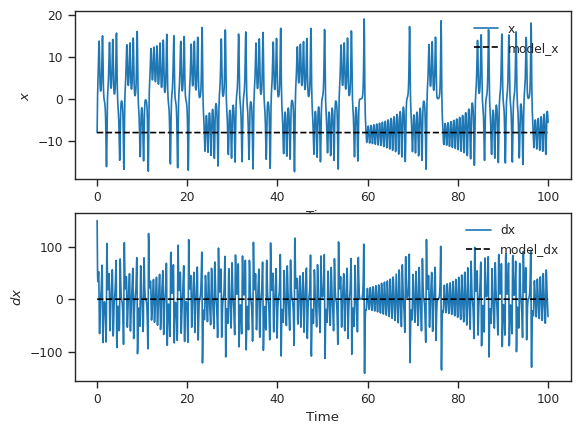

In [7]:
fig, ax = plt.subplots(2,1)
ax[0].plot(ts, partial_xs, label="x")
ax[1].plot(ts, partial_dxs, label="dx")
ax[0].plot(ts, xs_learned, 'k--', label="model_x")
ax[1].plot(ts, np.zeros(len(ts)), 'k--', label="model_dx")
ax[0].set(xlabel="Time", ylabel="$x$")
ax[1].set(xlabel="Time", ylabel="$dx$")
ax[0].legend(loc='best', frameon=False)
ax[1].legend(loc='best', frameon=False)

## Part B - The Hankel Matrix

Part A failed because we tried to fit Markovian dynamics to a partially observed state.
There are no Markovian dynamics for partially observed states.
Partially observed states exhibit effective dynamics that appear to have memory (and noise).
The Hankel matrix is a way to create variables that account for memory.
We will try two variations.
First, we will just try to learn dynamics directly on the columns of the Hankel matrix.
This is not going to work if the memory we need is long.
Then, we will use SVD to reduce the dimensionality of the Hankel matrix before attempting to learn the dynamics.

Your data are $x(t_1),\dots,x(t_m)$.
The Hankel matrix is:

$$
\mathbf{H}_\ell = \begin{bmatrix}
x(t_1) & x(t_2) & x(t_3) & \dots x(t_{m-\ell})\\
x(t_2) & x(t_3) & x(t_4) & \dots x(t_{m-\ell+1})\\
\vdots & \vdots & \vdots & \dots \vdots\\
x(t_\ell) & x(t_{\ell+1}) & x(t_{\ell+3}) \dots & x(t_m)
\end{bmatrix}
$$

Write a function that forms the Hankel matrix given the data and $\ell$.

**Answer:**

In [6]:
def make_hankel(xs, ell):
    """Write a good docstring."""
    # write your code here
    m = len(xs)
    H = np.zeros((ell, m-ell+1))
    for i in range(m-ell+1):
        H[:, i] = xs[i:i+ell]
    return H
    pass

## Part C - Apply SINDY on the Hankel matrix

Form the Hankel matrices for $x(t)$ and $\dot{x}(t)$ for $\ell=5$.
Try to represent the dynamics with a third degree polynomial.
Validate your results.
Do not expect this work very well.

**Answer:**

In [7]:
# as many code blocks and markdown blocks as you want

hankel_xs = make_hankel(partial_xs, 5)
hankel_dxs = make_hankel(partial_dxs, 5)

In [11]:
hankel_xs.shape

(5, 1996)

In [9]:
poly = PolynomialFeatures(degree=3, interaction_only=True)
hankel_Phi = poly.fit_transform(hankel_xs.T)

thetas = sparsify_dynamics(hankel_Phi, hankel_dxs.T, 0.025)

In [12]:
# Simulate with the learned dynamics
def f_learned(x, t, thetas, poly):
    phi = poly.fit_transform(x.reshape(1, -1)).flatten()
    dx = np.zeros(x.shape[0])
    for j in range(x.shape[0]):
        dx[j] = np.dot(thetas[:, j], phi)
    return dx

xs_learned = scipy.integrate.odeint(lambda x, t: f_learned(x, t, thetas, poly), hankel_xs.T[0,:], ts)

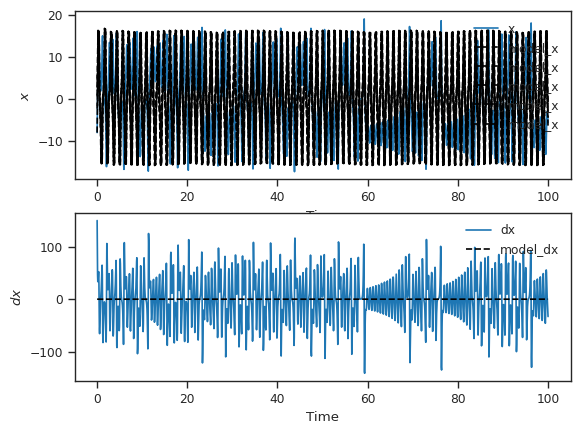

In [13]:
fig, ax = plt.subplots(2,1)
ax[0].plot(ts, partial_xs, label="x")
ax[1].plot(ts, partial_dxs, label="dx")
ax[0].plot(ts, xs_learned, 'k--', label="model_x")
ax[1].plot(ts, np.zeros(len(ts)), 'k--', label="model_dx")
ax[0].set(xlabel="Time", ylabel="$x$")
ax[1].set(xlabel="Time", ylabel="$dx$")
ax[0].legend(loc='best', frameon=False)
ax[1].legend(loc='best', frameon=False)

## Part D - Do SVD on the Hankel matrix

Let's pick a big $\ell$. Say $\ell = 100$:
+ Form the corresponding Hankel matrix and then do SVD on it.
+ Plot the explained variance as a function of the number of singular values.
+ How much variance do you explain with three dimensions (this is the intrinsic dimensionality of the dynamical system)?
+ Visualize the first three POD modes.
+ Project the Hankel matrix columns to three dimensions (POD amplitudes/principal components).
+ Plot the time series of each one of the principal components.
+ Plot the 3D trajectory of the principal components.

**Answer:**

In [19]:
# as many code blocks and markdown blocks as you want

hankel_xs = make_hankel(partial_xs, 100)

U, S, V = np.linalg.svd(hankel_xs)

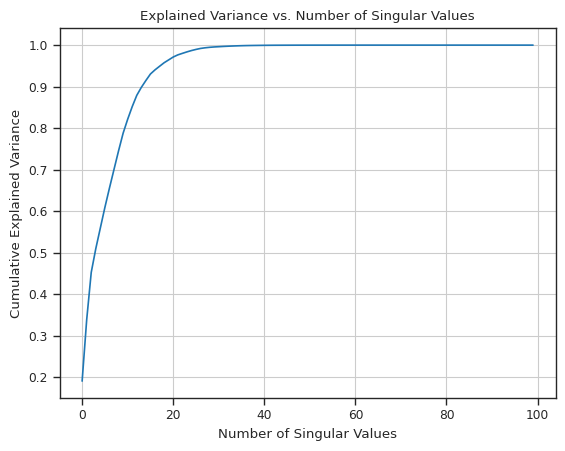

In [12]:
explained_variance = (S**2) / np.sum(S**2)
cumulative_variance = np.cumsum(explained_variance)

plt.figure()
plt.plot(cumulative_variance)
plt.xlabel("Number of Singular Values")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs. Number of Singular Values")
plt.grid(True)
plt.show()

In [13]:
variance_explained_3d = cumulative_variance[2]
print(f"Variance from 3 dimensions: {variance_explained_3d:.4f}")

Variance explained with 3 dimensions: 0.4525


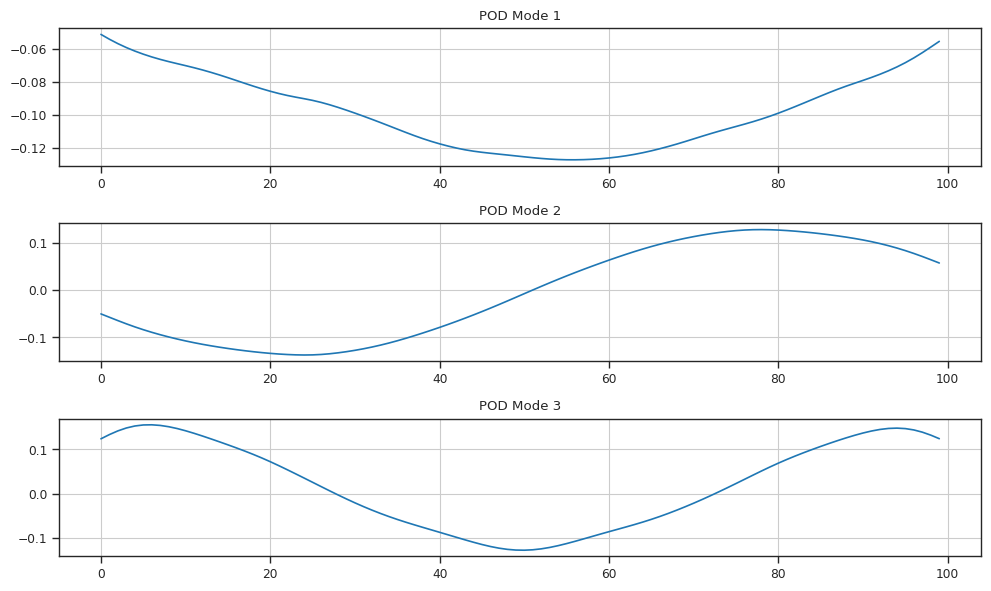

In [14]:
plt.figure(figsize=(10, 6))
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.plot(U[:, i])
    plt.title(f"POD Mode {i + 1}")
    plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
projected_data = U[:, :3].T @ hankel_xs

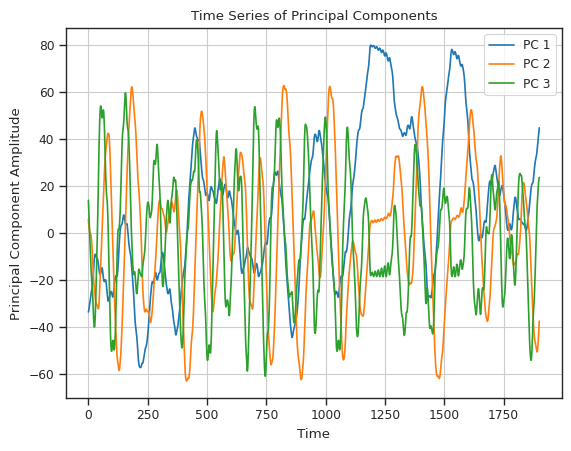

In [16]:
plt.figure()
for i in range(3):
    plt.plot(projected_data[i, :], label=f"PC {i + 1}")
plt.xlabel("Time")
plt.ylabel("Principal Component Amplitude")
plt.title("Time Series of Principal Components")
plt.legend()
plt.grid(True)
plt.show()

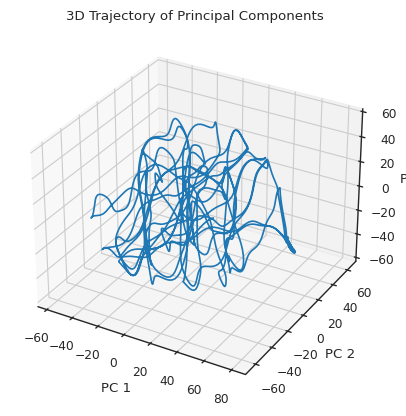

In [17]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(projected_data[0, :], projected_data[1, :], projected_data[2, :])
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")
ax.set_title("3D Trajectory of Principal Components")
plt.show()

## Part E - Find the time derivatives of the principal components of the Hankel matrix

To do SINDY, we need to have time derivatives.
So, you have to find the time derivatives of the principal components of the Hankel matrix.
You have two options:
+ Work out analytically how the observed `partial_dxs` will project on the POD modes, or;
+ Use numerical differentiation to find the required time derivatives (Google around for the best Python library for numerical differentiation). In this case, simple finite differences should work.

**Answer:**

In [34]:
# as many code blocks and markdown blocks as you want

projected_ts = ts[:1901]

d_projected_data = np.gradient(projected_data, projected_ts, axis=1)

## Part F - Do SINDY on the principal components of the Hankel matrix

You are now ready to do SINDY on the principal components of the Hankel matrix.
Use a polynomial of degree 5 as the right-hand-side.
Try to validate your results.

**Answer:**

In [40]:
# as many code blocks and markdown blocks as you want

poly = PolynomialFeatures(degree=5)
projected_Phi = poly.fit_transform(projected_data.T)

thetas = sparsify_dynamics(projected_Phi, d_projected_data.T, 0.025)

In [41]:
x0_projected = projected_data[:, 0]

projected_xs_learned = scipy.integrate.odeint(lambda x, t: f_learned(x, t, thetas, poly), x0_projected, ts)

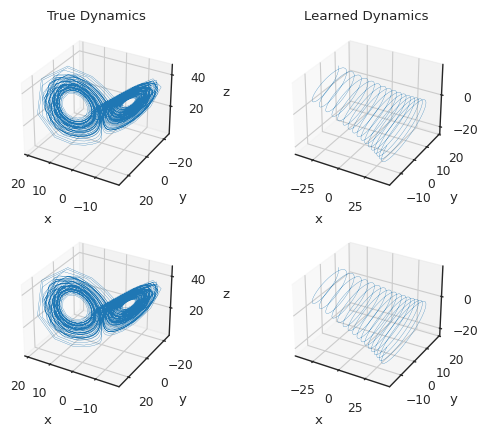

In [42]:
fig = plt.figure()
ax1 = fig.add_subplot(221, projection='3d')
steps = int(20/dt)
ax1.plot(xs[:steps, 0], xs[:steps, 1], xs[:steps, 2], lw=0.2)
ax1.set(xlabel='x', ylabel='y', zlabel='z', title='True Dynamics')
ax1.view_init(30, 120)

ax2 = fig.add_subplot(222, projection='3d')
ax2.plot(projected_xs_learned[:steps, 0], projected_xs_learned[:steps, 1], projected_xs_learned[:steps, 2], lw=0.2)
ax2.set(xlabel='x', ylabel='y', zlabel='z', title='Learned Dynamics')
ax1.view_init(30, 120)

ax3 = fig.add_subplot(223, projection='3d')
ax3.plot(xs[:, 0], xs[:, 1], xs[:, 2], lw=0.2)
ax3.set(xlabel='x', ylabel='y', zlabel='z')
ax3.view_init(30, 120)

ax4 = fig.add_subplot(224, projection='3d')
ax4.plot(projected_xs_learned[:, 0], projected_xs_learned[:, 1], projected_xs_learned[:, 2], lw=0.2)
ax4.set(xlabel='x', ylabel='y', zlabel='z')
ax3.view_init(30, 120);

# Problem 2 - SINDY with measurement noise and no derivatives

Let's get back to the Lorenz system. This time, we are going to assume that we have access to the full state, but we do not have the derivative, and the measurements are corrupted by noise.
So, your available data are:

In [75]:
eta = 0.01
noisy_x = xs + eta * np.random.normal(0, 1.0, xs.shape)

Review the package [derivative](https://pypi.org/project/derivative/) (which part of the `pysindy` ecosystem) and:
- Use a suitable method to estimate the derivative dx/dt from the noisy data `noisy_xs`.
- Apply SINDY to the denoised data and the numerical derivatives.
- Validate your results.

**Answer:**

In [44]:
!pip install pysindy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 kB 3.4 MB/s eta 0:00:00


In [76]:
from derivative import dxdt

noisy_dx = np.empty((2000,3))

noisy_dx[:,0] = dxdt(noisy_x[:,0], ts, kind="savitzky_golay", left=.5, right=.5, order=3)
noisy_dx[:,1] = dxdt(noisy_x[:,1], ts, kind="savitzky_golay", left=.5, right=.5, order=3)
noisy_dx[:,2] = dxdt(noisy_x[:,2], ts, kind="savitzky_golay", left=.5, right=.5, order=3)

In [169]:
from scipy.signal import savgol_filter

denoised_x = np.empty((2000,3))

denoised_x[:,0] = savgol_filter(noisy_x[:,0], window_length=13, polyorder=2)
denoised_x[:,1] = savgol_filter(noisy_x[:,1], window_length=13, polyorder=2)
denoised_x[:,2] = savgol_filter(noisy_x[:,2], window_length=13, polyorder=2)

In [170]:
poly = PolynomialFeatures(degree=5)

Phi_denoised = poly.fit_transform(denoised_x)
thetas_noisy = sparsify_dynamics(Phi_denoised, noisy_dx, 0.025)

In [171]:
xs_learned = scipy.integrate.odeint(lambda x, t: f_learned(x, t, thetas_noisy, poly), x0, ts)

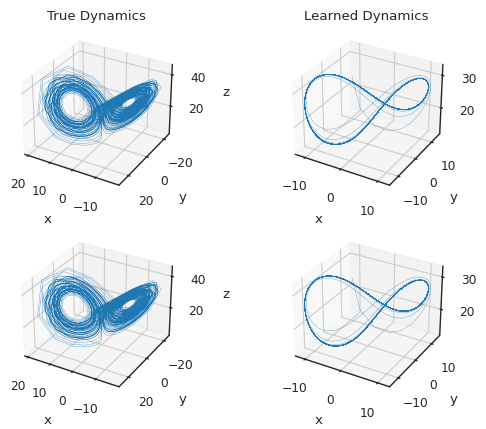

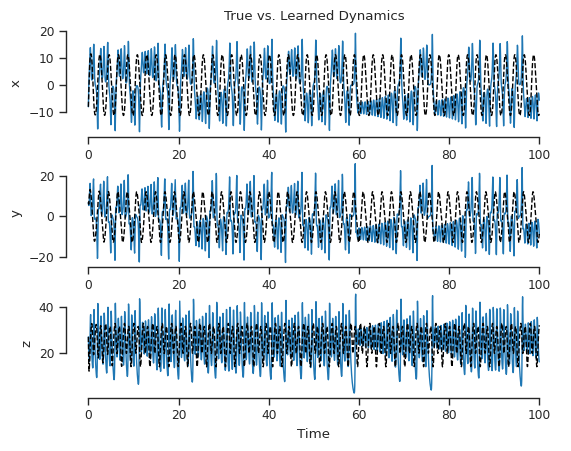

In [172]:
fig = plt.figure()
ax1 = fig.add_subplot(221, projection='3d')
steps = int(20/dt)
ax1.plot(noisy_x[:steps, 0], noisy_x[:steps, 1], noisy_x[:steps, 2], lw=0.2)
ax1.set(xlabel='x', ylabel='y', zlabel='z', title='True Dynamics')
ax1.view_init(30, 120)

ax2 = fig.add_subplot(222, projection='3d')
ax2.plot(xs_learned[:steps, 0], xs_learned[:steps, 1], xs_learned[:steps, 2], lw=0.2)
ax2.set(xlabel='x', ylabel='y', zlabel='z', title='Learned Dynamics')
ax1.view_init(30, 120)

ax3 = fig.add_subplot(223, projection='3d')
ax3.plot(noisy_x[:, 0], noisy_x[:, 1], noisy_x[:, 2], lw=0.2)
ax3.set(xlabel='x', ylabel='y', zlabel='z')
ax3.view_init(30, 120)

ax4 = fig.add_subplot(224, projection='3d')
ax4.plot(xs_learned[:, 0], xs_learned[:, 1], xs_learned[:, 2], lw=0.2)
ax4.set(xlabel='x', ylabel='y', zlabel='z')
ax3.view_init(30, 120);

fig = plt.figure()
ax1 = fig.add_subplot(311)
steps = int(20/dt)
ax1.plot(ts[:steps], noisy_x[:steps, 0], lw=1.0, label='True Dynamics')
ax1.plot(ts[:steps], xs_learned[:steps, 0], 'k--', lw=1.0, label='Learned Dynamics')
ax1.set(xlabel='Time', ylabel='x', title='True vs. Learned Dynamics')
sns.despine(trim=True);

ax2 = fig.add_subplot(312)
ax2.plot(ts[:steps], noisy_x[:steps, 1], lw=1.0, label='True Dynamics')
ax2.plot(ts[:steps], xs_learned[:steps, 1], 'k--', lw=1.0, label='Learned Dynamics')
ax2.set(xlabel='Time', ylabel='y')

ax3 = fig.add_subplot(313)
ax3.plot(ts[:steps], noisy_x[:steps, 2], lw=1.0, label='True Dynamics')
ax3.plot(ts[:steps], xs_learned[:steps, 2], 'k--', lw=1.0, label='Learned Dynamics')
ax3.set(xlabel='Time', ylabel='z')
sns.despine(trim=True);

I know this does not look quite like the example but this is the best I could get after a lot of experimentation with various window lengths and polynomial orders in the savgol filter.

# Problem 3 - Physics-informed Neural Networks for Solving a Neo-Hookean Hyperelasticity Problem

*The original version of this problem was developed by Atharva Hans as a companion to [this](https://youtu.be/o9JaZGWekWQ).

Consider a neo-Hookean square body defined on $(x,y) \in [0,1]^2$. Let $\mathbf{u}(x,y) = (u_1, u_2)$ describe the displacement field for this body.
This body is subjected to the following displacement boundary conditions:

$$
u_1(0,y) = 0,
$$

$$
u_2(0,y) = 0,
$$

$$
u_1(1,y) = \delta,
$$

$$
u_2(1,y) = 0,
$$

with $\delta$ referring to the applied displacement along the x-direction.

For this hyperelastic material, the stored energy $E_b$ in the body can be expressed in as:

$$
E_b[\mathbf{u}(\cdot)] = \int_{[0,1]^2}\left\{\frac{1}{2}(\sum_{i=1}^2\sum_{j=1}^2{F_{ij}^2} - 2)- \ln(\det(\mathbf{F})) + 50\ln(\det(\mathbf{F}))^2\right\} dxdy,
$$

with

$$
\mathbf{F} = \mathbf{I} + \nabla \mathbf{u},
$$

where $\mathbf{I}$ is an identity matrix.

The final orientation of this body is described by a displacement field that minimizes the stored energy $E_b$.
The idea is to use a neural network to approximate the displacement field and train it by minimizing the stored energy $E_b$.

To automatically satisfy the boundary conditions, we will use this approximation:
$$
u_1(x,y) = \delta - \delta(1-x) + x(1-x)N_1(x,y;\theta),
$$
and,
$$
u_2(x,y) = x(1-x)N_2(x,y;\theta)
$$
where $N_1(x,y;\theta)$ and $N_2(x,y;\theta)$ are neural networks.

## Part A

Solve the problem above for $\delta=0.1$ using a physics-informed neural network (PINN).
Use separate neural networks for $N_1(x,y;\theta)$ and $N_2(x,y;\theta)$.
Start with a multi-layer perceptron with 3 hidden layers, each with 128 units, and tanh activations.
Add a Fourier feature layer at the beginning of the network.
Feel free to change the architecture if you think it is necessary.

Use `equinox` for the neural networks and `optax` for the optimization.
Use a sampling average of 32 collocation points to compute the integral of the stored energy.
Use the Adam optimizer with a learning rate of 0.001 for 1000 iterations to debug.
Feel free to play with the learning rate, the number of collocation points, and the number of iterations.

Show the evolution of the loss function over the iterations.
Plot the final displacement field (plot $u_1(x,y)$ and $u_2(x,y)$ separately).

*Put your answer here. Use as many markdown and code blocks as you want.*

In [2]:
!pip install equinox
!pip install optax

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 2.1 MB/s eta 0:00:00


In [4]:
# your code here
import jax
import jax.numpy as jnp
import equinox as eqx
import optax
import matplotlib.pyplot as plt
from tqdm import tqdm

key = jax.random.PRNGKey(42)

In [5]:
# Fourier feature layer
class FourierFeatureTransform(eqx.Module):
    B: jax.Array  # Fourier basis matrix

    def __init__(self, num_frequencies, key, scale=1.0):
        key_B, _ = jax.random.split(key)
        self.B = jax.random.normal(key_B, (num_frequencies, 2)) * scale

    def __call__(self, x):
        proj = 2 * jnp.pi * jnp.dot(self.B, x)
        return jnp.concatenate([jnp.sin(proj), jnp.cos(proj)])

In [6]:
# Define N1 network
class N1(eqx.Module):
    fourier: FourierFeatureTransform
    mlp: eqx.nn.MLP

    def __init__(self, num_freq, key):
        key_f, key_mlp = jax.random.split(key)
        self.fourier = FourierFeatureTransform(num_freq, key_f)
        in_size = 2 * num_freq
        self.mlp = eqx.nn.MLP(in_size, 1, 128, 3, activation=jnp.tanh, key=key_mlp)

    def __call__(self, x, y):
        features = self.fourier(jnp.array([x, y]))
        return self.mlp(features).squeeze()

In [7]:
# Define N2 network
class N2(eqx.Module):
    fourier: FourierFeatureTransform
    mlp: eqx.nn.MLP

    def __init__(self, num_freq, key):
        key_f, key_mlp = jax.random.split(key)
        self.fourier = FourierFeatureTransform(num_freq, key_f)
        in_size = 2 * num_freq
        self.mlp = eqx.nn.MLP(in_size, 1, 128, 3, activation=jnp.tanh, key=key_mlp)

    def __call__(self, x, y):
        features = self.fourier(jnp.array([x, y]))
        return self.mlp(features).squeeze()

In [8]:
# Displacement functions with BCs built-in
def u1(x, y, n1, delta=0.1):
    return delta * x + x * (1 - x) * n1(x, y)

def u2(x, y, n2):
    return x * (1 - x) * n2(x, y)

In [9]:
# Compute integrand of the energy functional
def compute_integrand(x, y, n1, n2, delta):
    # Compute gradients of u1 and u2
    def u1_fn(x, y):
        return u1(x, y, n1, delta)
    du1dx = jax.grad(u1_fn, argnums=0)(x, y)
    du1dy = jax.grad(u1_fn, argnums=1)(x, y)

    def u2_fn(x, y):
        return u2(x, y, n2)
    du2dx = jax.grad(u2_fn, argnums=0)(x, y)
    du2dy = jax.grad(u2_fn, argnums=1)(x, y)

    F = jnp.eye(2) + jnp.array([[du1dx, du1dy], [du2dx, du2dy]])
    det_F = jnp.linalg.det(F)
    det_F = jnp.maximum(det_F, 1e-6)  # Ensure positivity for log

    term1 = 0.5 * (jnp.sum(F**2) - 2)
    term2 = -jnp.log(det_F)
    term3 = 50 * (jnp.log(det_F))**2
    return term1 + term2 + term3

In [10]:
# Training setup
delta = 0.1
num_freq = 64
batch_size = 32
num_iterations = 1000
learning_rate = 0.001

# Initialize models
key, key_n1, key_n2 = jax.random.split(key, 3)
n1 = N1(num_freq, key_n1)
n2 = N2(num_freq, key_n2)
model = (n1, n2)

In [11]:
# Optimizer
optim = optax.adam(learning_rate)
opt_state = optim.init(eqx.filter(model, eqx.is_array))

In [12]:
# Loss and grad function
@eqx.filter_value_and_grad
def loss_fn(model, x_batch, y_batch, delta):
    n1, n2 = model
    integrand = jax.vmap(compute_integrand, in_axes=(0, 0, None, None, None))(
        x_batch, y_batch, n1, n2, delta
    )
    return jnp.mean(integrand)

In [13]:
# Training loop
loss_history = []
progress = tqdm(range(num_iterations), desc="Training")
for step in progress:
    key, subkey = jax.random.split(key)
    x_batch = jax.random.uniform(subkey, (batch_size,))
    y_batch = jax.random.uniform(subkey, (batch_size,))

    loss, grads = loss_fn(model, x_batch, y_batch, delta)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    loss_history.append(loss.item())
    progress.set_postfix(loss=loss.item())

# Extract trained models
n1_trained, n2_trained = model

Training: 100%|██████████| 1000/1000 [06:24<00:00,  2.60it/s, loss=0.00527]


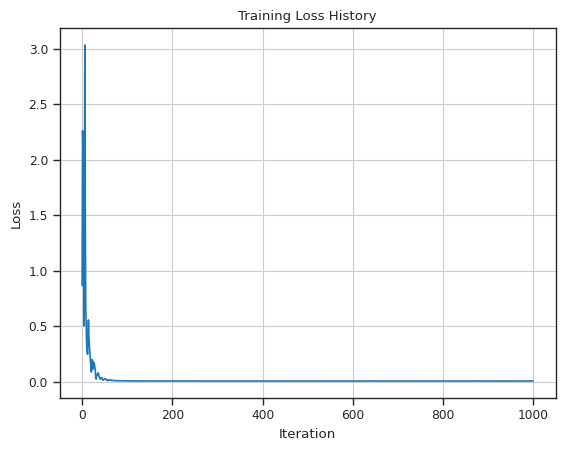

In [14]:
# Plot loss
plt.figure()
plt.plot(loss_history)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.grid(True)
plt.show()

In [15]:
# Plot displacement fields
x = jnp.linspace(0, 1, 100)
y = jnp.linspace(0, 1, 100)
x_grid, y_grid = jnp.meshgrid(x, y)
x_flat = x_grid.ravel()
y_flat = y_grid.ravel()

u1_vals = jax.vmap(u1, in_axes=(0, 0, None, None))(x_flat, y_flat, n1_trained, delta)
u2_vals = jax.vmap(u2, in_axes=(0, 0, None))(x_flat, y_flat, n2_trained)

u1_vals = u1_vals.reshape(x_grid.shape)
u2_vals = u2_vals.reshape(x_grid.shape)

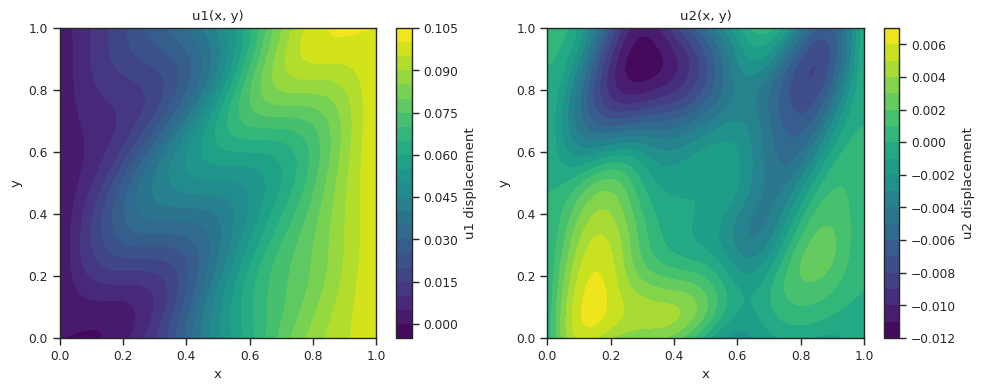

In [16]:
# Plot u1
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.contourf(x_grid, y_grid, u1_vals, levels=20, cmap='viridis')
plt.colorbar(label='u1 displacement')
plt.xlabel('x')
plt.ylabel('y')
plt.title('u1(x, y)')

# Plot u2
plt.subplot(122)
plt.contourf(x_grid, y_grid, u2_vals, levels=20, cmap='viridis')
plt.colorbar(label='u2 displacement')
plt.xlabel('x')
plt.ylabel('y')
plt.title('u2(x, y)')

plt.tight_layout()
plt.show()

## Part B

Solve the problem for $\delta=0.5$ using the same architecture as above.
It will likely fail to train.
If yes, then use the solution of $\delta=0.1$ as the initial guess for $\delta=0.2$, and then use the solution of $\delta=0.2$ as the initial guess for $\delta=0.3$, and so on, until you reach $\delta=0.5$.
This is called transfer learning.

At the end, plot the final displacement field for $\delta=0.5$.

*Put your answer here. Use as many markdown and code blocks as you want.*

In [17]:
# your code here
delta_steps = [0.1, 0.2, 0.3, 0.4, 0.5]

key, key_n1, key_n2 = jax.random.split(key, 3)
model = (N1(num_freq, key_n1), N2(num_freq, key_n2))

In [18]:
# Transfer learning loop
for delta in delta_steps:
    print(f"\n=== Training δ={delta} ===")

    # Reinitialize optimizer for each delta
    optim = optax.adam(learning_rate)
    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    # Loss and grad function (same as Part A)
    @eqx.filter_value_and_grad
    def loss_fn(model, x_batch, y_batch, delta):
        n1, n2 = model
        integrand = jax.vmap(compute_integrand, in_axes=(0, 0, None, None, None))(
            x_batch, y_batch, n1, n2, delta
        )
        return jnp.mean(integrand)

    # Training loop
    loss_history = []
    progress = tqdm(range(num_iterations), desc=f"δ={delta}")
    for step in progress:
        key, subkey = jax.random.split(key)
        x_batch = jax.random.uniform(subkey, (batch_size,))
        y_batch = jax.random.uniform(subkey, (batch_size,))

        loss, grads = loss_fn(model, x_batch, y_batch, delta)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        loss_history.append(loss.item())
        progress.set_postfix(loss=loss.item())


=== Training δ=0.1 ===


δ=0.1: 100%|██████████| 1000/1000 [06:55<00:00,  2.41it/s, loss=0.00519]



=== Training δ=0.2 ===


δ=0.2: 100%|██████████| 1000/1000 [06:35<00:00,  2.53it/s, loss=0.0232]



=== Training δ=0.3 ===


δ=0.3: 100%|██████████| 1000/1000 [06:41<00:00,  2.49it/s, loss=0.047]



=== Training δ=0.4 ===


δ=0.4: 100%|██████████| 1000/1000 [06:49<00:00,  2.44it/s, loss=0.0808]



=== Training δ=0.5 ===


δ=0.5: 100%|██████████| 1000/1000 [06:57<00:00,  2.39it/s, loss=0.132]


In [19]:
# Final visualization for δ=0.5
delta_final = 0.5
n1_final, n2_final = model

# Generate displacement fields
x = jnp.linspace(0, 1, 100)
y = jnp.linspace(0, 1, 100)
x_grid, y_grid = jnp.meshgrid(x, y)
x_flat = x_grid.ravel()
y_flat = y_grid.ravel()

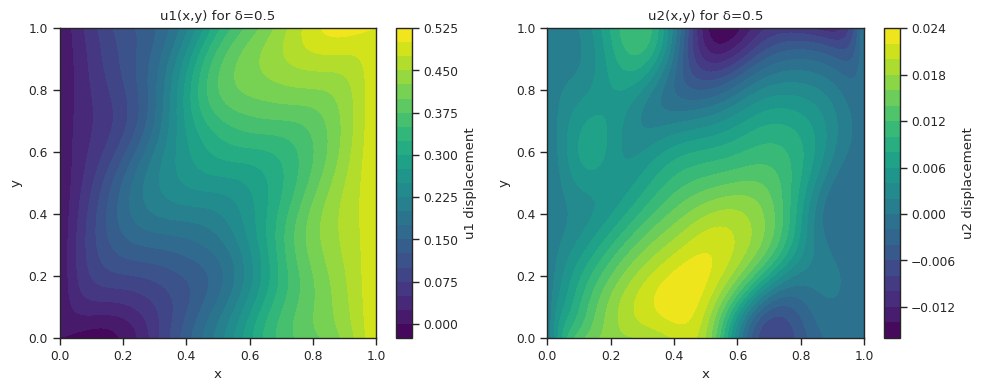

In [20]:
u1_vals = jax.vmap(u1, in_axes=(0, 0, None, None))(x_flat, y_flat, n1_final, delta_final)
u2_vals = jax.vmap(u2, in_axes=(0, 0, None))(x_flat, y_flat, n2_final)

# Reshape and plot
u1_vals = u1_vals.reshape(x_grid.shape)
u2_vals = u2_vals.reshape(x_grid.shape)

plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.contourf(x_grid, y_grid, u1_vals, levels=20, cmap='viridis')
plt.colorbar(label='u1 displacement')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'u1(x,y) for δ={delta_final}')

plt.subplot(122)
plt.contourf(x_grid, y_grid, u2_vals, levels=20, cmap='viridis')
plt.colorbar(label='u2 displacement')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'u2(x,y) for δ={delta_final}')

plt.tight_layout()
plt.show()

## Part C

Solve the parametric problem for $\delta \in [0,0.5]$. That is, build a neural network that takes $\delta$ as input and outputs the displacement field. To do this:
+ Modify the loss function to:

$$
\mathcal{L} = \int_0^{0.5} \int_{[0,1]^2} \left\{\frac{1}{2}(\sum_{i}\sum_{j}{F_{ij}^2} - 2)- \ln(\det(\mathbf{F})) + 50\ln(\det(\mathbf{F}))^2\right\} dxdy d\delta.
$$

+ Modify the neural networks to take $\delta$ as input, say $N_1(x,y;\delta;\theta)$ and $N_2(x,y;\delta;\theta)$. Your field will be $\mathbf{u}(x,y;\delta;\theta)$.
Use the following architecture for the neural networks:

$$
N_1(x,y;\delta) = \sum_{i=1}^n b_{1,i}(\delta)t_{1,i}(x,y).
$$

Here, $n$ is your choice (start with $n=10$), $b_{1,i}$ is a neural network that takes $\delta$ as input and outputs a scalar, and $t_{1,i}(x,y)$ is a multi-layer perceptron with 3 hidden layers, each with 128 units, and tanh activations, and Fourier features at the beginning. The same applies to $N_2(x,y;\delta)$. This representation resembles an expansion in terms of basis functions.
The same architecture appears in DeepONet.

Plot the $x$ and $y$ displacement at $x=0.5, y=0.5$ as a function of $\delta$.

*Put your answer here. Use as many markdown and code blocks as you want.*

In [21]:
# your code here

# Trunk network (processes spatial coordinates)
class TrunkNetwork(eqx.Module):
    fourier: FourierFeatureTransform
    mlp: eqx.nn.MLP

    def __init__(self, num_freq, out_dim, key):
        key_f, key_mlp = jax.random.split(key)
        self.fourier = FourierFeatureTransform(num_freq, key_f)
        in_size = 2 * num_freq
        self.mlp = eqx.nn.MLP(in_size, out_dim, 128, 3,
                             activation=jnp.tanh, key=key_mlp)

    def __call__(self, x, y):
        features = self.fourier(jnp.array([x, y]))
        return self.mlp(features).squeeze()

In [22]:
# Branch network (processes δ parameter)
class BranchNetwork(eqx.Module):
    mlp: eqx.nn.MLP

    def __init__(self, out_dim, key):
        self.mlp = eqx.nn.MLP(1, out_dim, 128, 3,
                            activation=jnp.tanh, key=key)

    def __call__(self, delta):
        return self.mlp(jnp.array([delta])).squeeze()

In [23]:
# Combined N1 network (parametric)
class ParametricN1(eqx.Module):
    branch: BranchNetwork
    trunk: TrunkNetwork

    def __init__(self, num_basis, num_freq, key):
        key_b, key_t = jax.random.split(key)
        self.branch = BranchNetwork(num_basis, key_b)
        self.trunk = TrunkNetwork(num_freq, num_basis, key_t)

    def __call__(self, x, y, delta):
        return jnp.dot(self.branch(delta), self.trunk(x, y))

In [24]:
# Combined N2 network (parametric)
class ParametricN2(eqx.Module):
    branch: BranchNetwork
    trunk: TrunkNetwork

    def __init__(self, num_basis, num_freq, key):
        key_b, key_t = jax.random.split(key)
        self.branch = BranchNetwork(num_basis, key_b)
        self.trunk = TrunkNetwork(num_freq, num_basis, key_t)

    def __call__(self, x, y, delta):
        return jnp.dot(self.branch(delta), self.trunk(x, y))

In [25]:
# Displacement functions with parametric δ
def u1(x, y, delta, n1):
    return delta * x + x * (1 - x) * n1(x, y, delta)

def u2(x, y, delta, n2):
    return x * (1 - x) * n2(x, y, delta)

# Energy integrand calculation
def compute_integrand(x, y, delta, n1, n2):
    def u1_fn(x, y):
        return u1(x, y, delta, n1)
    du1dx = jax.grad(u1_fn, argnums=0)(x, y)
    du1dy = jax.grad(u1_fn, argnums=1)(x, y)

    def u2_fn(x, y):
        return u2(x, y, delta, n2)
    du2dx = jax.grad(u2_fn, argnums=0)(x, y)
    du2dy = jax.grad(u2_fn, argnums=1)(x, y)

    F = jnp.eye(2) + jnp.array([[du1dx, du1dy], [du2dx, du2dy]])
    det_F = jnp.linalg.det(F)
    det_F = jnp.maximum(det_F, 1e-6)

    term1 = 0.5 * (jnp.sum(F**2) - 2)
    term2 = -jnp.log(det_F)
    term3 = 50 * (jnp.log(det_F))**2
    return term1 + term2 + term3

In [26]:
# Training setup
num_basis = 10
num_freq = 64
batch_size = 128
num_iterations = 5000
learning_rate = 0.001

# Initialize models
key = jax.random.PRNGKey(42)
key_n1, key_n2 = jax.random.split(key)
n1 = ParametricN1(num_basis, num_freq, key_n1)
n2 = ParametricN2(num_basis, num_freq, key_n2)
model = (n1, n2)

In [27]:
# Optimizer
optim = optax.adam(learning_rate)
opt_state = optim.init(eqx.filter(model, eqx.is_array))

In [28]:
# Loss and grad function
@eqx.filter_value_and_grad
def loss_fn(model, batch):
    n1, n2 = model
    x_batch, y_batch, delta_batch = batch
    integrand = jax.vmap(compute_integrand, in_axes=(0, 0, 0, None, None))(
        x_batch, y_batch, delta_batch, n1, n2
    )
    return jnp.mean(integrand)

In [29]:
# Training loop
loss_history = []
progress = tqdm(range(num_iterations), desc="Training")
for step in progress:
    key, *subkeys = jax.random.split(key, 4)
    x_batch = jax.random.uniform(subkeys[0], (batch_size,))
    y_batch = jax.random.uniform(subkeys[1], (batch_size,))
    delta_batch = jax.random.uniform(subkeys[2], (batch_size,)) * 0.5

    batch = (x_batch, y_batch, delta_batch)
    loss, grads = loss_fn(model, batch)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)

    loss_history.append(loss.item())
    progress.set_postfix(loss=loss.item())

Training: 100%|██████████| 5000/5000 [52:30<00:00,  1.59it/s, loss=0.165]


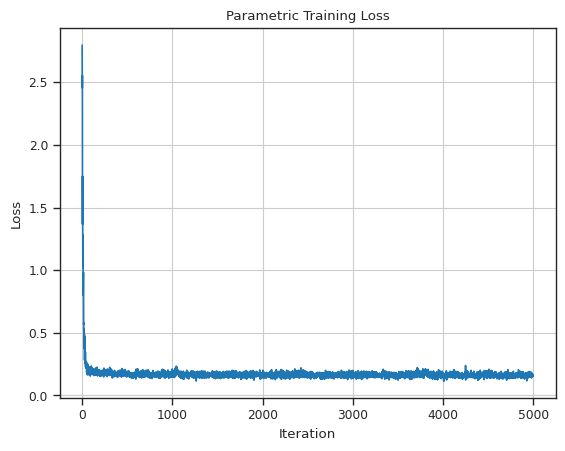

In [30]:
# Plot training loss
plt.figure()
plt.plot(loss_history)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Parametric Training Loss")
plt.grid(True)
plt.show()

In [31]:
# Plot displacements at (0.5, 0.5) vs δ
delta_test = jnp.linspace(0, 0.5, 100)
x_test = jnp.full_like(delta_test, 0.5)
y_test = jnp.full_like(delta_test, 0.5)

n1_trained, n2_trained = model
u1_vals = jax.vmap(u1, in_axes=(0, 0, 0, None))(x_test, y_test, delta_test, n1_trained)
u2_vals = jax.vmap(u2, in_axes=(0, 0, 0, None))(x_test, y_test, delta_test, n2_trained)

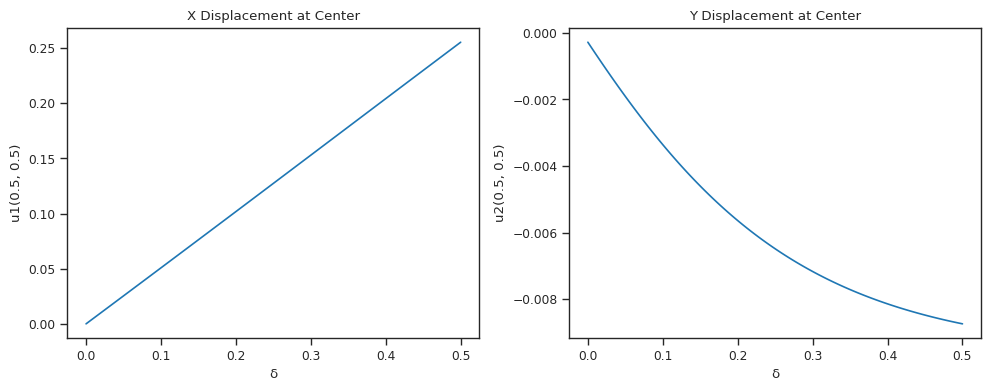

In [32]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(delta_test, u1_vals)
plt.xlabel("δ")
plt.ylabel("u1(0.5, 0.5)")
plt.title("X Displacement at Center")

plt.subplot(122)
plt.plot(delta_test, u2_vals)
plt.xlabel("δ")
plt.ylabel("u2(0.5, 0.5)")
plt.title("Y Displacement at Center")

plt.tight_layout()
plt.show()

In [ ]:
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p
p